# [Analysis of 3k T cells from cancer](https://icbi-lab.github.io/scirpy/tutorials/tutorial_3k_tcr.html)

In this tutorial, we re-analyze single-cell TCR/RNA-seq data from [Wu et al. (`Wu2020`)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE139555) generated on the 10x Genomics platform. The original dataset consists of >140k T cells
from 14 treatment-naive patients across four different types of cancer.
For this tutorial, to speed up computations, we use a downsampled version of 3k cells.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import warnings

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
from matplotlib import pyplot as plt

In [3]:
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.5.3 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.6.1 leidenalg==0.8.3


The dataset ships with the `scirpy` package. We can conveniently load it from the :mod:`~scirpy.datasets` module:

In [4]:
adata = ir.datasets.wu2020_3k()

`adata` is a regular `AnnData` object with additional, IR-specific columns in obs. For more information, check the page about Scirpy’s [data structure](https://icbi-lab.github.io/scirpy/usage-principles.html#data-structure).

For more information about our T-cell receptor model, see [receptor-model](https://icbi-lab.github.io/scirpy/ir-biology.html#receptor-model).

In [5]:
adata.shape

(3000, 30727)

In [6]:
adata.obs

,cluster_orig,patient,sample,source,clonotype_orig,multi_chain,IR_VJ_1_locus,IR_VJ_2_locus,IR_VDJ_1_locus,IR_VDJ_2_locus,...,IR_VJ_1_c_gene,IR_VJ_2_c_gene,IR_VDJ_1_c_gene,IR_VDJ_2_c_gene,IR_VJ_1_cdr3_nt,IR_VJ_2_cdr3_nt,IR_VDJ_1_cdr3_nt,IR_VDJ_2_cdr3_nt,has_ir,batch
LN1_GTAGGCCAGCGTAGTG-1-19,4.4-FOS,Lung1,LN1,NAT,lung1.tn.C223,False,nan,nan,TRB,TRB,...,nan,nan,TRBC2,TRBC2,None,None,TGTGCCAGCAGCTTAATGCGGCTAGCGGGAGATACGCAGTATTTT,TGTGCAAGTCGCTTAGCGGTTTTATCGACTAGCGGGAGTGTCGGAG...,True,19
RN2_AGAGCGACAGATTGCT-1-27,4.4-FOS,Renal2,RN2,NAT,renal2.tnb.C1362,False,TRA,nan,TRB,nan,...,TRAC,nan,TRBC1,nan,TGTGCTGTGAGGGGGAATAACAATGCCAGACTCATGTTT,None,TGTGCCAGCAGCTTTGGAACGGTGGCTGAAGCTTTCTTT,None,True,27
LN1_GTCATTTCAATGAAAC-1-19,8.2-Tem,Lung1,LN1,NAT,lung1.tn.C25,False,TRA,nan,TRB,nan,...,TRAC,nan,TRBC1,nan,TGTGCTGTGAGGTTGGGTAACCAGTTCTATTTT,None,TGCAGTGCTAGAGATGGAGGGGGGGGGAACACTGAAGCTTTCTTT,None,True,19
LN2_GACACGCAGGTAGCTG-2-2,8.6-KLRB1,Lung2,LN2,NAT,lung2.tn.C2452,False,nan,nan,TRB,nan,...,nan,nan,TRBC2,nan,None,None,TGTGCCAGCAGCCAAGGTCAGGGACAGGATTTTAACTACGAGCAGT...,None,True,2
LN2_GCACTCTCAGGGATTG-2-2,4.4-FOS,Lung2,LN2,NAT,lung2.tn.C5631,False,TRA,nan,TRB,nan,...,TRAC,nan,TRBC1,nan,TGTGCAGCAAGCGACCCCACGGTCGAGGCAGGAACTGCTCTGATCTTT,None,TGTGCCAGCAGCTTGACCGTTAACACTGAAGCTTTCTTT,None,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RT3_GCAGTTAGTATGAAAC-1-6,4.2-RPL32,Renal3,RT3,Tumor,renal3.tnb.C176,False,TRA,nan,TRB,nan,...,TRAC,nan,TRBC2,nan,TGTGCTGCGATGGATAGCAACTATCAGTTAATCTGG,None,TGTGCCACCAAGGACAGGGAAGACACCGGGGAGCTGTTTTTT,None,True,6
LT1_GACGTGCTCTCAAGTG-1-24,8.2-Tem,Lung1,LT1,Tumor,lung1.tn.C151,False,TRA,nan,nan,nan,...,TRAC,nan,nan,nan,TGTGCTTATAGGAGTTCCCTTGGTGGTGCTACAAACAAGCTCATCTTT,None,None,None,True,24
ET3_GCTGGGTAGACCTTTG-1-3,3.1-MT,Endo3,ET3,Tumor,endo3.tn.C76,False,nan,nan,TRB,nan,...,nan,nan,TRBC2,nan,None,None,TGTGCCAGCAGCCGGACAGGGGGGGATTCCGGGGAGCTGTTTTTT,None,True,3
RT1_TAAGAGATCCTTAATC-1-8,4.5-IL6ST,Renal1,RT1,Tumor,renal1.tnb.C83,False,TRA,nan,TRB,nan,...,TRAC,nan,TRBC2,nan,TGTGCAATGAGCGAGATTTCTGGTGGCTACAATAAGCTGATTTTT,None,TGTGCCTGGAGTGACAGGTCAGACGAGCAGTACTTC,None,True,8


**Importing data**

 `scirpy` natively supports reading `IR` data from [Cellranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger)(10x), [TraCeR](https://github.com/Teichlab/tracer)(Smart-seq2)
    or the [AIRR rearrangement schema](https://docs.airr-community.org/en/latest/datarep/rearrangements.html) and provides helper functions to import other data types. We provide a [dedicated tutorial on data loading](https://icbi-lab.github.io/scirpy/tutorials/tutorial_io.html#importing-data) with more details.

This particular dataset has been imported using `scirpy.io.read_10x_vdj` and merged with transcriptomics data using `scirpy.pp.merge_with_ir`. The exact procedure is described in `scirpy.datasets.wu2020`.
    
## Preprocess Transcriptomics data

Transcriptomics data needs to be filtered and preprocessed as with any other single-cell dataset.
We recommend following the [scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)
and the best practice paper by [Luecken et al.](https://www.embopress.org/doi/10.15252/msb.20188746)

In [7]:
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(adata, min_genes=100)

In [8]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1000)
sc.pp.log1p(adata)

For the _Wu2020_ dataset, the authors already provide clusters and UMAP coordinates.
Instead of performing clustering and cluster annotation ourselves, we will just use
the provided data. The clustering and annotation methodology is
described in [their paper](https://doi.org/10.1038/s41586-020-2056-8).

In [9]:
adata.obsm["X_umap"] = adata.obsm["X_umap_orig"]

In [10]:
mapping = {
    "nan": "other",
    "3.1-MT": "other",
    "4.1-Trm": "CD4_Trm",
    "4.2-RPL32": "CD4_RPL32",
    "4.3-TCF7": "CD4_TCF7",
    "4.4-FOS": "CD4_FOSS",
    "4.5-IL6ST": "CD4_IL6ST",
    "4.6a-Treg": "CD4_Treg",
    "4.6b-Treg": "CD4_Treg",
    "8.1-Teff": "CD8_Teff",
    "8.2-Tem": "CD8_Tem",
    "8.3a-Trm": "CD8_Trm",
    "8.3b-Trm": "CD8_Trm",
    "8.3c-Trm": "CD8_Trm",
    "8.4-Chrom": "other",
    "8.5-Mitosis": "other",
    "8.6-KLRB1": "other",
}
adata.obs["cluster"] = [mapping[x] for x in adata.obs["cluster_orig"]]

Let's inspect the UMAP plots. The first three panels show the UMAP plot colored by sample, patient and cluster.
We don't observe any clustering of samples or patients that could hint at batch effects.

The last three panels show the UMAP colored by the T cell markers _CD8_, _CD4_, and _FOXP3_.
We can confirm that the markers correspond to their respective cluster labels.


... storing 'cluster' as categorical


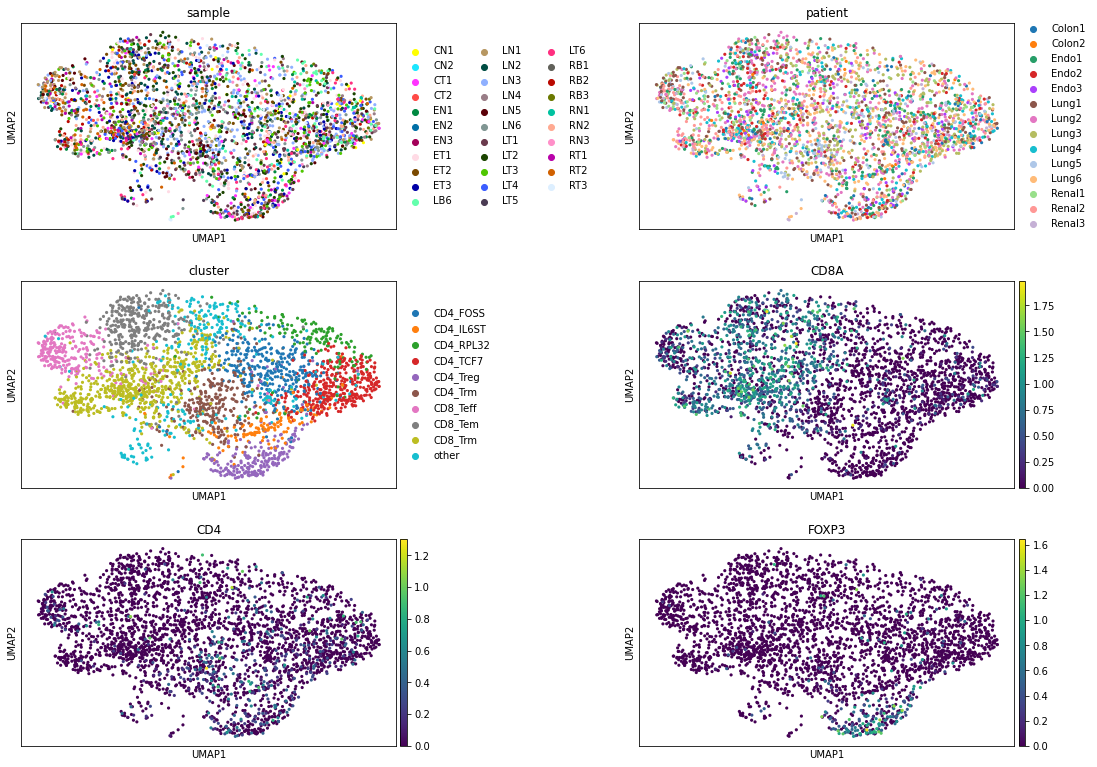

In [11]:
sc.pl.umap(
    adata,
    color=["sample", "patient", "cluster", "CD8A", "CD4", "FOXP3"],
    ncols=2,
    wspace=0.5,
)

## TCR Quality Control

While most of T cell receptors have exactly one pair of α and β chains, up to one third of
T cells can have *dual TCRs*, i.e. two pairs of receptors originating from different alleles (`Schuldt2019`).

Using the `scirpy.tl.chain_qc` function, we can add a summary
about the T cell receptor compositions to `adata.obs`. We can visualize it using `scirpy.pl.group_abundance`.

**chain pairing**

   - *Orphan chain* refers to cells that have either a single alpha or beta receptor chain.
   - *Extra chain* refers to cells that have a full alpha/beta receptor pair, and an additional chain.
   - *Multichain* refers to cells with more than two receptor pairs detected. These cells are likely doublets.

**receptor type and receptor subtype**

   - `receptor_type` refers to a coarse classification into `BCR` and `TCR`. Cells both `BCR` and `TCR` chains 
      are labelled as `ambiguous`. 
   - `receptor_subtype` refers to a more specific classification into α/β, ɣ/δ, IG-λ, and IG-κ chain configurations. 
    
   For more details, see :func:`scirpy.tl.chain_qc`. 

In [12]:
ir.tl.chain_qc(adata)

As expected, the dataset contains only α/β T-cell receptors: 

 **chain pairing**

  - *Orphan chain* refers to cells that have either a single alpha or beta receptor chain.
  - *Extra chain* refers to cells that have a full alpha/beta receptor pair, and an additional chain.
  - *Multichain* refers to cells with more than two receptor pairs detected. These cells are likely doublets.

... storing 'receptor_type' as categorical
... storing 'receptor_subtype' as categorical
... storing 'chain_pairing' as categorical


<AxesSubplot:title={'center':'Number of cells in receptor_type by source'}, xlabel='receptor_type', ylabel='Number of cells'>

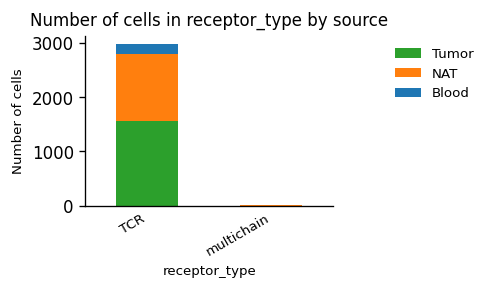

In [13]:
ir.pl.group_abundance(adata, groupby="receptor_type", target_col="source")

<AxesSubplot:title={'center':'Number of cells in receptor_subtype by source'}, xlabel='receptor_subtype', ylabel='Number of cells'>

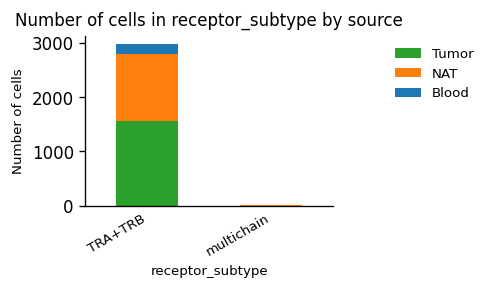

In [14]:
ir.pl.group_abundance(adata, groupby="receptor_subtype", target_col="source")

<AxesSubplot:title={'center':'Number of cells in chain_pairing by source'}, xlabel='chain_pairing', ylabel='Number of cells'>

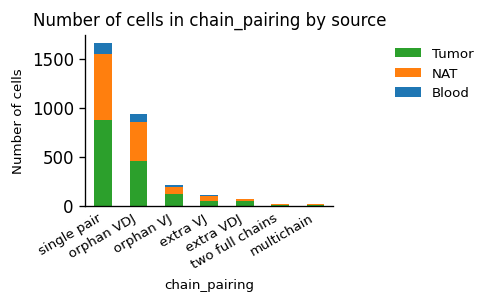

In [15]:
ir.pl.group_abundance(adata, groupby="chain_pairing", target_col="source")

Indeed, in this dataset, ~6% of cells have more than
one pair of productive T-cell receptors:

In [16]:
print(
    "Fraction of cells with more than one pair of TCRs: {:.2f}".format(
        np.sum(
            adata.obs["chain_pairing"].isin(
                ["extra VJ", "extra VDJ", "two full chains"]
            )
        )
        / adata.n_obs
    )
)

Fraction of cells with more than one pair of TCRs: 0.06


Next, we visualize the _Multichain_ cells on the UMAP plot and exclude them from downstream analysis:

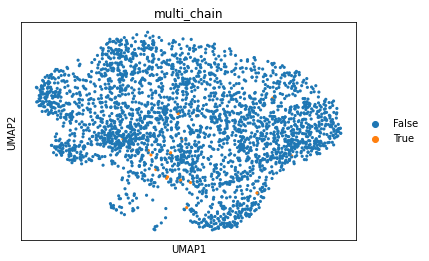

In [17]:
sc.pl.umap(adata, color="multi_chain")

In [18]:
adata = adata[adata.obs["multi_chain"] != "True", :].copy()

## Define clonotypes and clonotype clusters

In this section, we will define and visualize `clonotypes` and `clonotype clusters`.

*Scirpy* implements a network-based approach for clonotype definition. The steps to create and visualize the clonotype-network are analogous to the construction of a neighborhood graph from transcriptomics data with *scanpy*.

### Compute CDR3 neighborhood graph and define clonotypes

`scirpy.pp.ir_neighbors` computes a neighborhood graph based on `CDR3 <CDR>` nucleotide (`nt`) or amino acid (`aa`) sequences, either based on sequence identity or similarity.

Here, we define `clonotypes` based on nt-sequence identity.
In a later step, we will define `clonotype clusters` based on amino-acid similarity.

The function `scirpy.tl.define_clonotypes` will detect connected modules in the graph and annotate them as clonotypes. This will add a `clonotype` and `clonotype_size` column to `adata.obs`.

In [19]:
# using default parameters, `ir_neighbors` will compute nucleotide sequence identity
ir.pp.ir_neighbors(adata, receptor_arms="all", dual_ir="primary_only")
ir.tl.define_clonotypes(adata)

100%|██████████| 8887/8887 [00:00<00:00, 30555.60it/s]


To visualize the network we first call `scirpy.tl.clonotype_network` to compute the layout.
We can then visualize it using `scirpy.pl.clonotype_network`. We recommend setting the
`min_size` parameter to `>=2`, to prevent the singleton clonotypes from cluttering the network.

... storing 'clonotype' as categorical


array([<AxesSubplot:title={'center':'clonotype'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

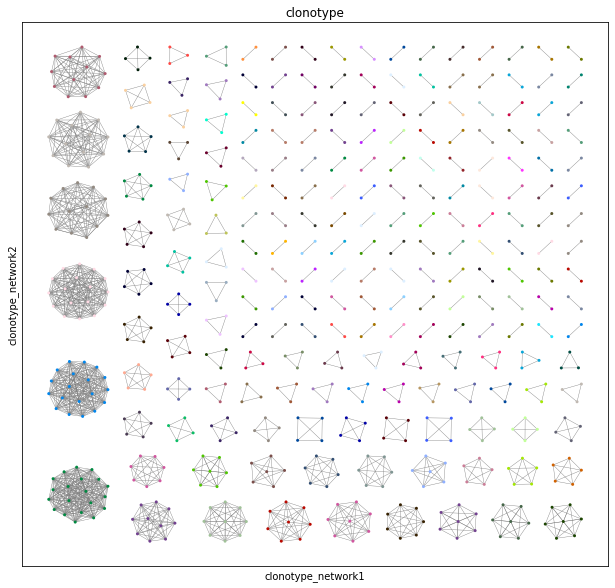

In [20]:
ir.tl.clonotype_network(adata, min_size=2)
ir.pl.clonotype_network(adata, color="clonotype", legend_loc="none")

### Re-compute CDR3 neighborhood graph and define clonotype clusters

We can now re-compute the neighborhood graph based on amino-acid sequence similarity
and define `clonotype clusters`.

To this end, we need to change set `metric="alignment"` and specify a `cutoff` parameter.
The distance is based on the [BLOSUM62](https://en.wikipedia.org/wiki/BLOSUM) matrix.
For instance, a distance of `10` is equivalent to 2 `R`s mutating into `N`.
This appoach was initially proposed as *TCRdist* by Dash et al. (`TCRdist`).

All cells with a distance between their CDR3 sequences lower than `cutoff` will be connected in the network.

In [21]:
sc.settings.verbosity = 4

In [22]:
ir.pp.ir_neighbors(
    adata,
    metric="alignment",
    sequence="aa",
    cutoff=15,
    receptor_arms="all",
    dual_ir="all",
)
ir.tl.define_clonotype_clusters(
    adata, partitions="connected", sequence="aa", metric="alignment", within_group=None
)

Initializing IrNeighbors object...
Finished initalizing IrNeighbors object.  (0:00:01)
Computing VJ pairwise distances...


100%|██████████| 595/595 [00:17<00:00, 33.66it/s]


Finished computing VJ pairwise distances. (0:00:17)
Computing VDJ pairwise distances...


100%|██████████| 1081/1081 [00:31<00:00, 34.19it/s]

Finished computing VDJ pairwise distances. (0:00:31)
Started comstructing VJ coord-dictionary...



100%|██████████| 3748/3748 [00:00<00:00, 12897.40it/s]

Finished constructing VJ coord-dictionary (0:00:00)
Started comstructing VDJ coord-dictionary...



100%|██████████| 3498/3498 [00:00<00:00, 7778.41it/s] 

Finished constructing VDJ coord-dictionary (0:00:00)
Constructing cell x cell distance matrix...



100%|██████████| 22017/22017 [00:00<00:00, 84466.38it/s]

Finished constructing cell x cell distance matrix.  (0:00:00)
    Started converting distances to connectivities. 
    Finished converting distances to connectivities.  (0:00:00)


In [23]:
ir.tl.clonotype_network(adata, min_size=4, sequence="aa", metric="alignment")

Compared to the previous plot, we observe slightly larger clusters that are not necessarily fully connected any more.

... storing 'ct_cluster_aa_alignment' as categorical


array([<AxesSubplot:title={'center':'ct_cluster_aa_alignment'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

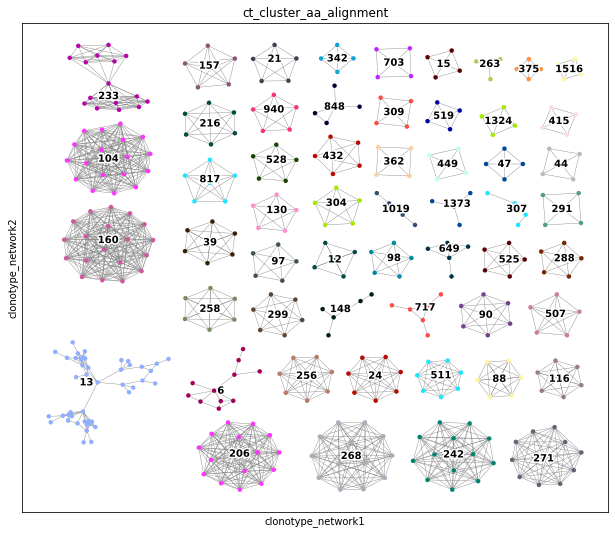

In [24]:
ir.pl.clonotype_network(
    adata,
    color="ct_cluster_aa_alignment",
    legend_fontoutline=3,
    size=80,
    panel_size=(10, 9),
    legend_loc="on data"
)

Now we show the same graph, colored by patient.
We observe that for instance clonotypes 104 and 160 (center-left) are _private_, i.e. they contain cells from
a single sample only. On the other hand, for instance clonotype 233 (top-left) is _public_, i.e.
it is shared across patients _Lung5_ and _Lung1_ and _Lung3_.

array([<AxesSubplot:title={'center':'patient'}, xlabel='clonotype_network1', ylabel='clonotype_network2'>],
      dtype=object)

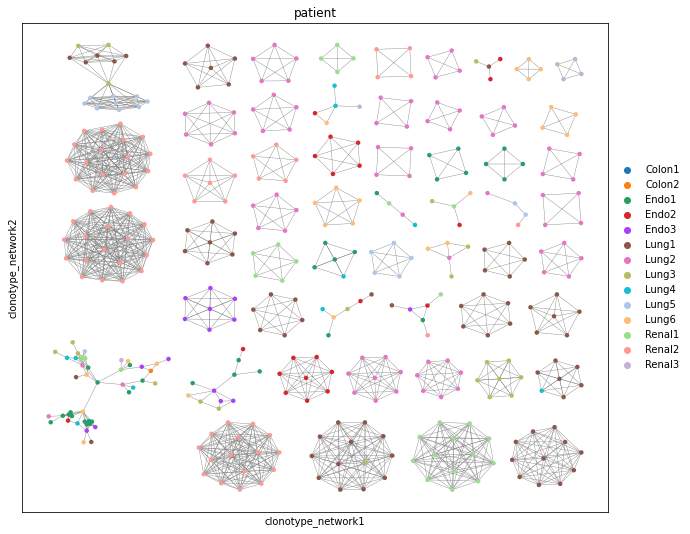

In [25]:
ir.pl.clonotype_network(adata, color="patient", size=80, panel_size=(10, 9))

We can now extract information (e.g. CDR3-sequences) from a specific clonotype cluster by subsetting `AnnData`.
For instance, we can find out that clonotype `233` does not have any detected :term:`VJ-chain`. 
In this context, the VJ-chain refers to a TCR-alpha chain. 

In [26]:
adata.obs.loc[
    adata.obs["ct_cluster_aa_alignment"] == "233",
    [
        "IR_VJ_1_cdr3",
        "IR_VJ_2_cdr3",
        "IR_VDJ_1_cdr3",
        "IR_VDJ_2_cdr3",
        "receptor_subtype",
    ],
]

,IR_VJ_1_cdr3,IR_VJ_2_cdr3,IR_VDJ_1_cdr3,IR_VDJ_2_cdr3,receptor_subtype
LN5_TGGACGCAGCCCAACC-1-7,None,None,CASSFRGTGELFF,None,TRA+TRB
LN1_CAGAATCGTCGCATCG-1-19,None,None,CASSYQGATEAFF,None,TRA+TRB
LN1_TCAATCTGTGTGAAAT-1-19,None,None,CASSYQGATEAFF,None,TRA+TRB
LT3_ACTTGTTTCGCATGAT-1-15,None,None,CASSYQGAGELFF,None,TRA+TRB
LN3_TTAGGACGTAAGAGAG-1-11,None,None,CASSYQGSTEAFF,None,TRA+TRB
LN5_AGACGTTAGTGAATTG-1-7,None,None,CASSFRGTGELFF,None,TRA+TRB
LN5_GTAGTCAGTCCGAAGA-1-7,None,None,CASSFRGTGELFF,None,TRA+TRB
LN5_ACTGAGTAGTGCGATG-1-7,None,None,CASSFRGTGELFF,None,TRA+TRB
LN3_GTCTCGTTCGTACGGC-1-11,None,None,CASSYQGSTEAFF,None,TRA+TRB
LN5_TTGCCGTTCACATGCA-1-7,None,None,CASSFRGTGELFF,None,TRA+TRB


### Including the V-gene in clonotype definition

Using the paramter `use_v_gene` in `~scirpy.tl.define_clonotypes`, we can enforce
clonotypes (or clonotype clusters) to have the same `V-gene`, and, therefore, the same `CDR1 and 2`
regions. Let's look for clonotype clusters with different V genes:

In [27]:
ir.tl.define_clonotype_clusters(
    adata,
    sequence="aa",
    metric="alignment",
    same_v_gene="primary_only",
    key_added="ct_cluster_aa_alignment_same_v",
)

In [28]:
# find clonotypes with more than one `clonotype_same_v`
ct_different_v = adata.obs.groupby("ct_cluster_aa_alignment").apply(
    lambda x: x["ct_cluster_aa_alignment_same_v"].unique().size > 1
)
ct_different_v = ct_different_v[ct_different_v].index.values
ct_different_v

['6', '12', '13', '90', '95', ..., '1507', '1518', '1814', '1857', '1860']
Length: 57
Categories (2396, object): ['0', '1', '2', '3', ..., '2392', '2393', '2394', '2395']

In [29]:
# Display the first 2 clonotypes with different v genes
adata.obs.loc[
    adata.obs["ct_cluster_aa_alignment"].isin(ct_different_v[:2]),
    [
        "ct_cluster_aa_alignment",
        "ct_cluster_aa_alignment_same_v",
        "IR_VJ_1_v_gene",
        "IR_VDJ_1_v_gene",
    ],
].sort_values("ct_cluster_aa_alignment").drop_duplicates().reset_index(drop=True)

,ct_cluster_aa_alignment,ct_cluster_aa_alignment_same_v,IR_VJ_1_v_gene,IR_VDJ_1_v_gene
0,6,6_nan_TRBV4-2_TCR,nan,TRBV4-2
1,6,6_nan_TRBV5-4_TCR,nan,TRBV5-4
2,6,6_nan_TRBV5-8_TCR,nan,TRBV5-8
3,6,6_nan_TRBV4-1_TCR,nan,TRBV4-1
4,6,6_nan_TRBV12-4_TCR,nan,TRBV12-4
5,6,6_nan_TRBV5-1_TCR,nan,TRBV5-1
6,6,6_nan_TRBV7-9_TCR,nan,TRBV7-9
7,6,6_nan_TRBV11-2_TCR,nan,TRBV11-2
8,6,6_nan_TRBV10-2_TCR,nan,TRBV10-2
9,12,12_nan_TRBV6-5_TCR,nan,TRBV6-5


## Clonotype analysis

### Clonal expansion

Let's visualize the number of expanded clonotypes (i.e. clonotypes consisting of more than one cell) by cell-type. The first option is to add a column with the `scirpy.tl.clonal_expansion` to `adata.obs` and overlay it on the UMAP plot.

In [30]:
ir.tl.clonal_expansion(adata)

`clonal_expansion` refers to expansion categories, i.e singleton clonotypes, clonotypes with 2 cells and more than 2 cells.
The `clonotype_size` refers to the absolute number of cells in a clonotype.

... storing 'ct_cluster_aa_alignment_same_v' as categorical
... storing 'clonal_expansion' as categorical


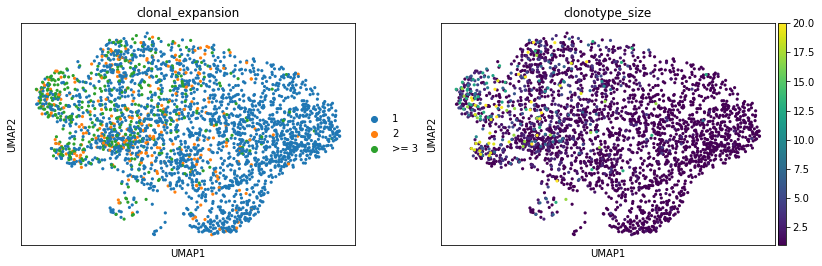

In [31]:
sc.pl.umap(adata, color=["clonal_expansion", "clonotype_size"])

The second option is to show the number of cells belonging to an expanded clonotype per category
in a stacked bar plot, using the :func:`scirpy.pl.clonal_expansion` plotting function.

<AxesSubplot:>

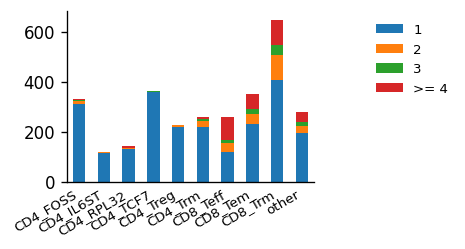

In [32]:
ir.pl.clonal_expansion(adata, groupby="cluster", clip_at=4, normalize=False)

The same plot, normalized to cluster size. Clonal expansion is a sign of positive selection
for a certain, reactive T-cell clone. It, therefore, makes sense that CD8+ effector T-cells
have the largest fraction of expanded clonotypes.

<AxesSubplot:>

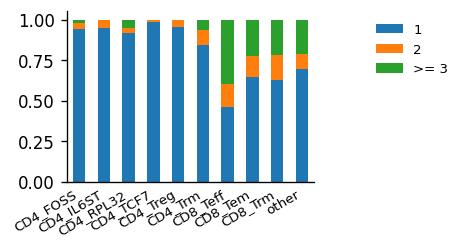

In [33]:
ir.pl.clonal_expansion(adata, "cluster")

Expectedly, the CD8+ effector T cells have the largest fraction of expanded clonotypes.

Consistent with this observation, they have the lowest :func:`scirpy.pl.alpha_diversity` of clonotypes.

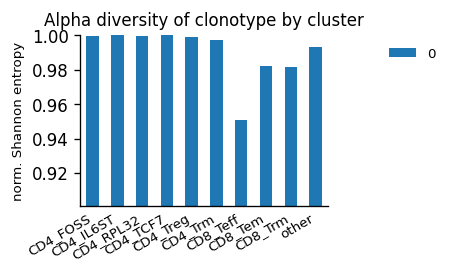

In [34]:
ax = ir.pl.alpha_diversity(adata, groupby="cluster")

### Clonotype abundance

The function `scirpy.pl.group_abundance` allows us to create bar charts for arbitrary categorial from `obs`. Here, we use it to show the distribution of the ten largest clonotypes across the cell-type clusters.

<AxesSubplot:title={'center':'Number of cells in clonotype by cluster'}, xlabel='clonotype', ylabel='Number of cells'>

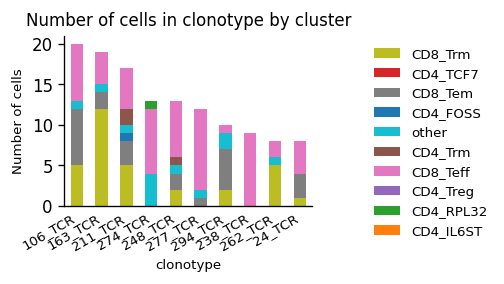

In [35]:
ir.pl.group_abundance(adata, groupby="clonotype", target_col="cluster", max_cols=10)

It might be beneficial to normalize the counts to the number of cells per sample to mitigate biases due to different sample sizes:

<AxesSubplot:title={'center':'Fraction of cluster in each clonotype'}, xlabel='clonotype', ylabel='Fraction of cells in sample'>

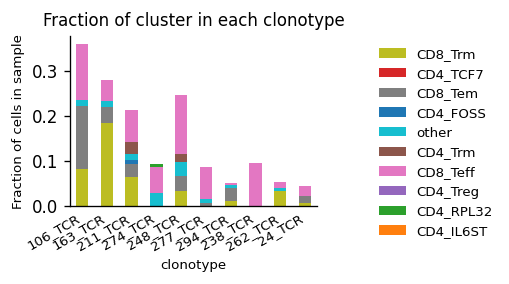

In [36]:
ir.pl.group_abundance(
    adata, groupby="clonotype", target_col="cluster", max_cols=10, normalize="sample"
)

Coloring the bars by patient gives us information about public and private clonotypes:
Some clonotypes are *private*, i.e. specific to a certain tissue, others are *public*, i.e. they are shared across different tissues.

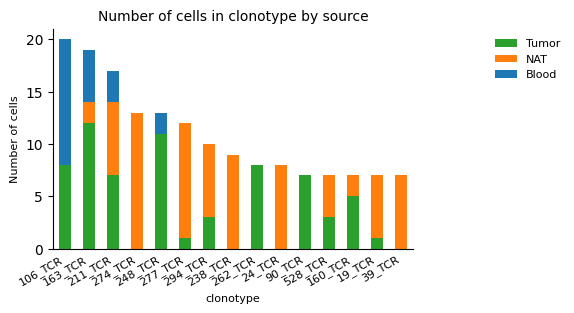

In [37]:
ax = ir.pl.group_abundance(
    adata, groupby="clonotype", target_col="source", max_cols=15, fig_kws={"dpi": 100}
)

However, clonotypes that are shared between *patients* are rare:

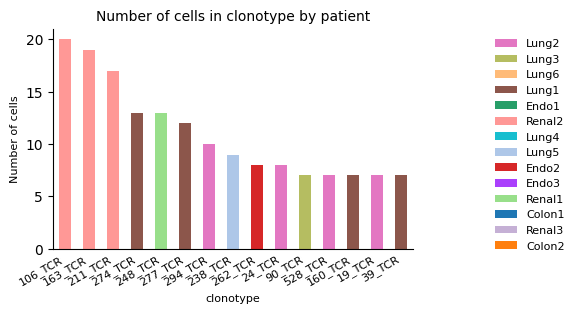

In [38]:
ax = ir.pl.group_abundance(
    adata, groupby="clonotype", target_col="patient", max_cols=15, fig_kws={"dpi": 100}
)

## Gene usage

`scirpy.tl.group_abundance` can also give us some information on VDJ usage.
We can choose any of the `{TRA,TRB}_{1,2}_{v,d,j,c}_gene` columns to make a stacked bar plot.
We use `max_col` to limit the plot to the 10 most abundant V-genes.

<AxesSubplot:title={'center':'Fraction of cluster in each IR_VJ_1_v_gene'}, xlabel='IR_VJ_1_v_gene', ylabel='Fraction of cells in cluster'>

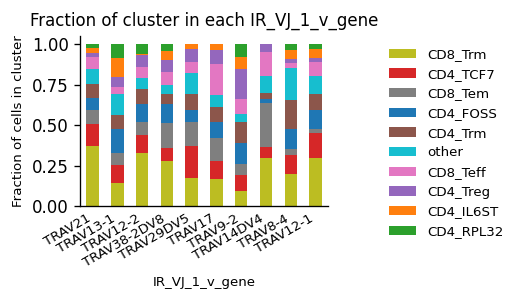

In [39]:
ir.pl.group_abundance(
    adata, groupby="IR_VJ_1_v_gene", target_col="cluster", normalize=True, max_cols=10
)

We can pre-select groups by filtering `adata`:

/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_nt_identity']['connectivities'] that happens to be dimensioned at n_obs×n_obs (2983×2983).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,
/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_nt_identity']['distances'] that happens to be dimensioned at n_obs×n_obs (2983×2983).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,
/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_alignment']['connectivities'

<AxesSubplot:title={'center':'Fraction of IR_VDJ_1_v_gene in each cluster'}, xlabel='cluster', ylabel='Fraction of cells in IR_VDJ_1_v_gene'>

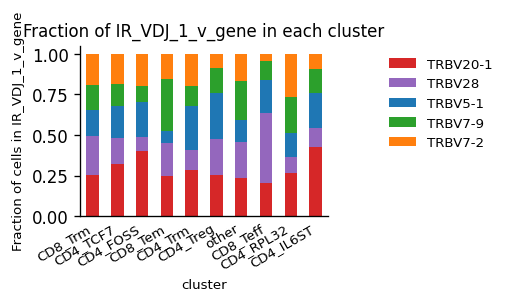

In [40]:
ir.pl.group_abundance(
    adata[
        adata.obs["IR_VDJ_1_v_gene"].isin(
            ["TRBV20-1", "TRBV7-2", "TRBV28", "TRBV5-1", "TRBV7-9"]
        ),
        :,
    ],
    groupby="cluster",
    target_col="IR_VDJ_1_v_gene",
    normalize=True,
)

The exact combinations of VDJ genes can be visualized as a Sankey-plot using `scirpy.pl.vdj_usage`.

<AxesSubplot:>

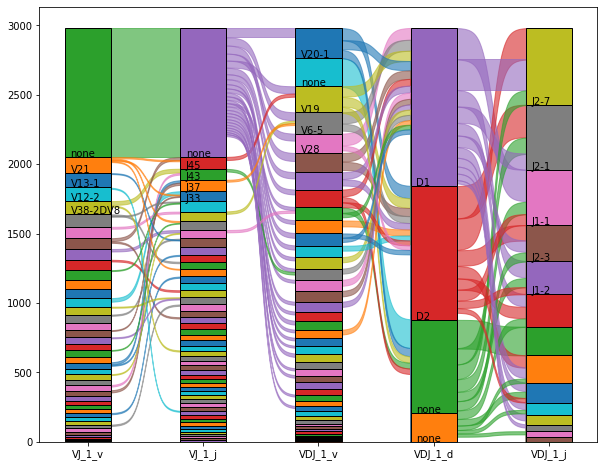

In [41]:
ir.pl.vdj_usage(adata, full_combination=False, max_segments=None, max_ribbons=30,fig_kws={'figsize':(10,8)})

We can also use this plot to investigate the exact VDJ composition of one (or several) clonotypes:

<AxesSubplot:>

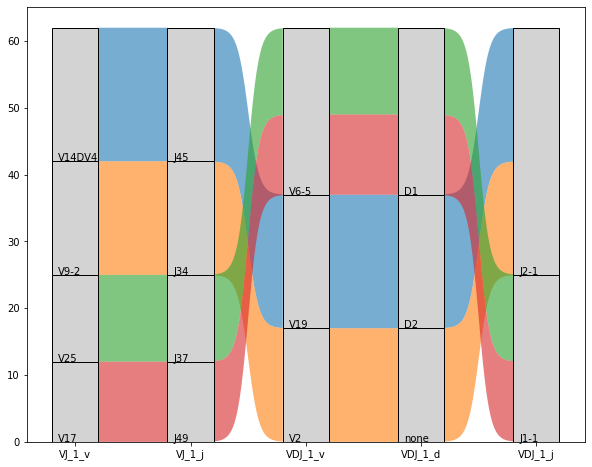

In [42]:
ir.pl.vdj_usage(
    adata[adata.obs["clonotype"].isin(["274_TCR", "277_TCR", "211_TCR", "106_TCR"]), :],
    max_ribbons=None,
    max_segments=100,
    fig_kws={'figsize':(10,8)}
)

### Spectratype plots

`~scirpy.pl.spectratype` plots give us information about the length distribution of CDR3 regions.

<AxesSubplot:title={'center':'Spectratype of IR_VJ_1_cdr3 by cluster'}, xlabel='IR_VJ_1_cdr3 length', ylabel='Number of cells'>

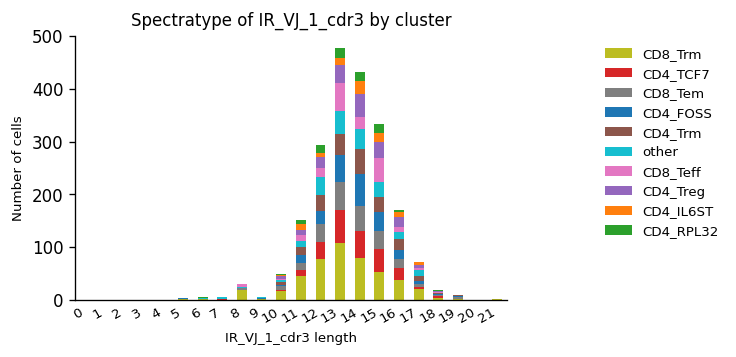

In [43]:
ir.pl.spectratype(adata, color="cluster", viztype="bar", fig_kws={"dpi": 120})

The same chart visualized as "ridge"-plot:

/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/scirpy/_plotting/base.py:256: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(order)


<AxesSubplot:title={'center':'Spectratype of IR_VJ_1_cdr3 by cluster'}, xlabel='IR_VJ_1_cdr3 length'>

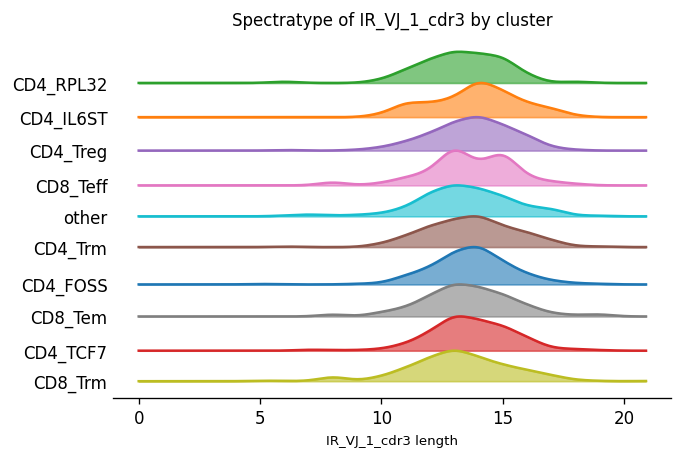

In [44]:
ir.pl.spectratype(
    adata,
    color="cluster",
    viztype="curve",
    curve_layout="shifted",
    fig_kws={"dpi": 120},
    kde_kws={"kde_norm": False},
)

A spectratype-plot by gene usage. To pre-select specific genes, we can simply filter the `adata` object before plotting.

/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_nt_identity']['connectivities'] that happens to be dimensioned at n_obs×n_obs (2983×2983).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,
/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_nt_identity']['distances'] that happens to be dimensioned at n_obs×n_obs (2983×2983).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  FutureWarning,
/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/anndata/compat/__init__.py:215: FutureWarning: During AnnData slicing, found matrix at .uns['ir_neighbors_aa_alignment']['connectivities'

<AxesSubplot:title={'center':'Spectratype of IR_VDJ_1_cdr3 by IR_VDJ_1_v_gene'}, xlabel='IR_VDJ_1_cdr3 length', ylabel='Fraction of cells in sample'>

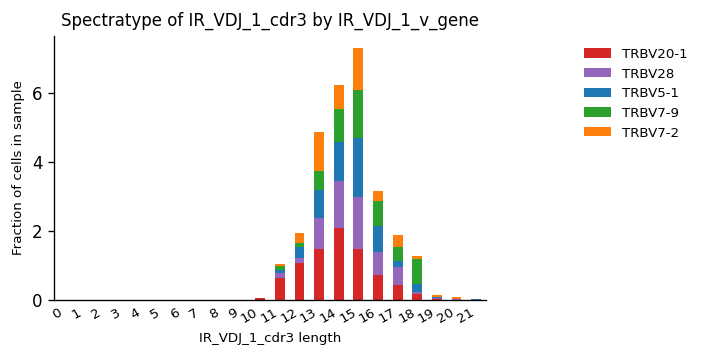

In [45]:
ir.pl.spectratype(
    adata[
        adata.obs["IR_VDJ_1_v_gene"].isin(
            ["TRBV20-1", "TRBV7-2", "TRBV28", "TRBV5-1", "TRBV7-9"]
        ),
        :,
    ],
    cdr3_col="IR_VDJ_1_cdr3",
    color="IR_VDJ_1_v_gene",
    normalize="sample",
    fig_kws={"dpi": 120},
)

## Comparing repertoires

### Repertoire simlarity and overlaps

Overlaps in the adaptive immune receptor repertoire of samples or sample groups enables to pinpoint important clonotype groups, as well as to provide a measure of similarity between samples.
Running Scirpy's `~scirpy.tl.repertoire_overlap` tool creates a matrix featuring the abundance of clonotypes in each sample. Additionally, it also computes a (Jaccard) distance matrix of samples as well as the linkage of hierarchical clustering.

In [46]:
df, dst, lk = ir.tl.repertoire_overlap(adata, "sample", inplace=False)
df.head()

clonotype,0_TCR,1_TCR,2_TCR,3_TCR,4_TCR,5_TCR,6_TCR,7_TCR,8_TCR,9_TCR,...,2505_TCR,2506_TCR,2507_TCR,2508_TCR,2509_TCR,2510_TCR,2511_TCR,2512_TCR,2513_TCR,2514_TCR
sample,,,,,,,,,,,,,,,,,,,,,
CN1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
CN2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CT1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CT2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
EN1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The distance matrix can be shown as a heatmap, while samples are reordered based on hierarchical clustering.

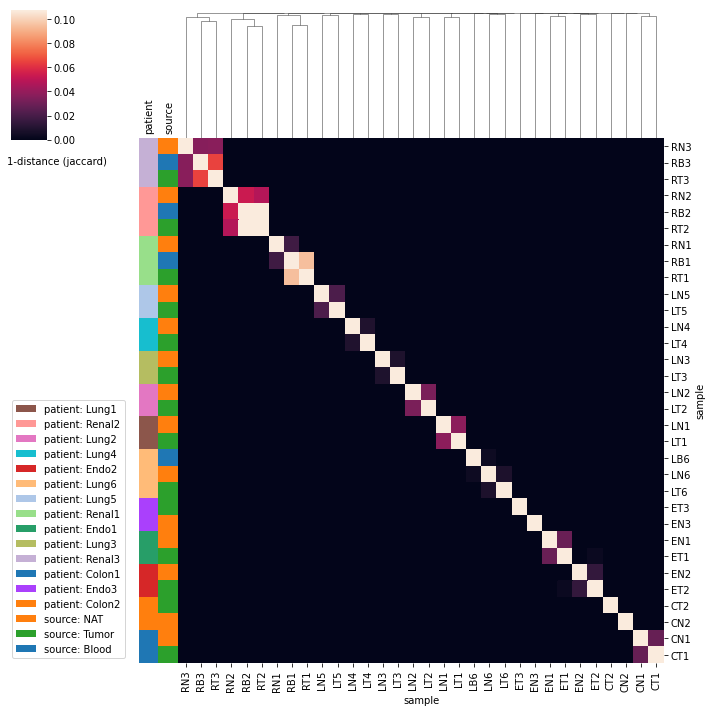

In [47]:
ir.pl.repertoire_overlap(adata, "sample", heatmap_cats=["patient", "source"])


A specific pair of samples can be compared on a scatterplot, where dot size corresponds to the number of clonotypes at a given coordinate.

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Repertoire overlap between LN2 and LT2'}, xlabel='Clonotype size in LN2', ylabel='Clonotype size in LT2'>

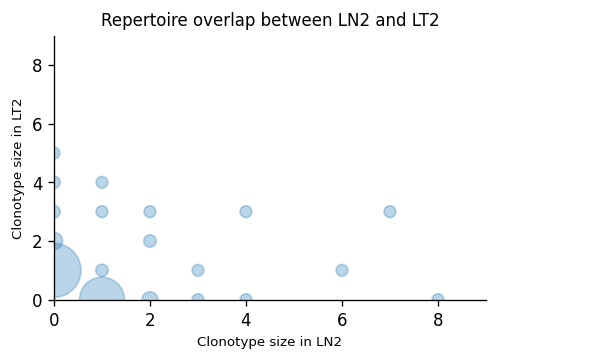

In [48]:
ir.pl.repertoire_overlap(
    adata, "sample", pair_to_plot=["LN2", "LT2"], fig_kws={"dpi": 120}
)

### Clonotypes preferentially occuring in a group

Clonotypes associated with an experimental group (a given cell type, samle or diagnosis) might be important candidates as biomarkers or disease drivers. Scirpy offers `~scirpy.tl.clonotype_imbalance` to rank clonotypes based on Fisher's exact test comparing the fractional presence of a given clonotype in two groups.

A possible grouping criterion could be Tumor vs. Control, separately for distinct tumor types. The site of the tumor can be extracted from patient metadata.

In [49]:
adata.obs["site"] = adata.obs["patient"].str.slice(stop=-1)

/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/scirpy/_tools/_clonotype_imbalance.py:273: RuntimeWarning: divide by zero encountered in double_scalars
  (case_mean_freq + global_minimum) / (control_mean_freq + global_minimum)
/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/scirpy/_tools/_clonotype_imbalance.py:273: RuntimeWarning: divide by zero encountered in log2
  (case_mean_freq + global_minimum) / (control_mean_freq + global_minimum)
/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/scirpy/_tools/_clonotype_imbalance.py:273: RuntimeWarning: divide by zero encountered in log2
  (case_mean_freq + global_minimum) / (control_mean_freq + global_minimum)
/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/scirpy/_tools/_clonotype_imbalance.py:273: RuntimeWarning: divide by zero encountered in double_scalars
  (case_mean_freq + global_minimum) / (control_mean_freq + global_minimum)
/home/vmuser/miniconda3/

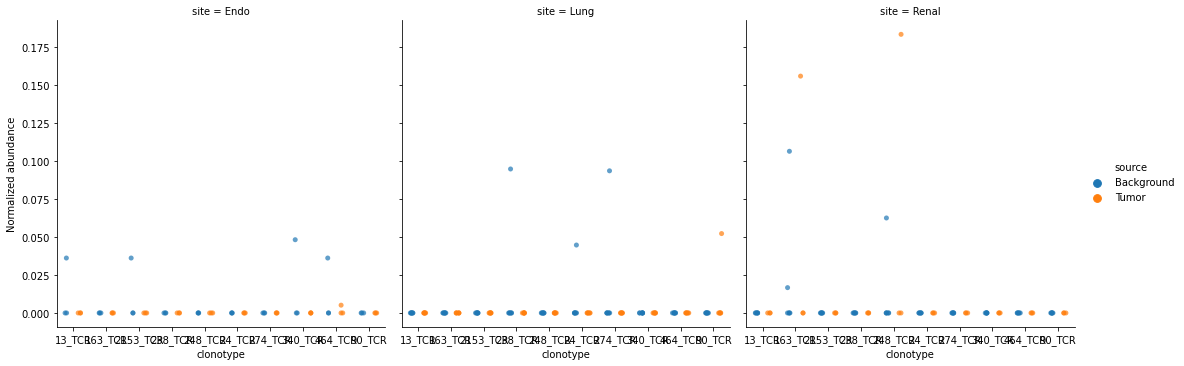

In [50]:
ir.pl.clonotype_imbalance(
    adata,
    replicate_col="sample",
    groupby="source",
    case_label="Tumor",
    additional_hue="site",
    plot_type="strip",
)

To get an idea how the above, top-ranked clonotypes compare to the bulk of all clonotypes, a Volcano plot is genereated, showing the `-log10 p-value` of the Fisher's test as a function of `log2(fold-change)` of the normalized proportion of a given clonotype in the test group compared to the control group. To avoid zero division, `0.01*(global minimum proportion)` was added to every normalized clonotype proportions.

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Volcano plot'}, xlabel='log2FoldChange', ylabel='-log10(p-value)'>

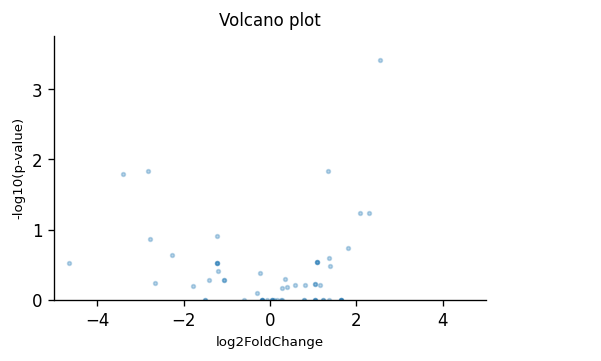

In [51]:
ir.pl.clonotype_imbalance(
    adata,
    replicate_col="sample",
    groupby="source",
    case_label="Tumor",
    additional_hue="diagnosis",
    plot_type="volcano",
    fig_kws={"dpi": 120},
)

## Integrating gene expression
### Clonotype imbalance among cell clusters

Leveraging the opportunity offered by close integeration with scanpy, transcriptomics-based data can be utilized directly. Using cell type annotation inferred from gene expression clusters, for example, clonotypes belonging to CD8+ effector T-cells and CD8+ tissue-resident memory T cells, can be compared.

In [52]:
freq, stat = ir.tl.clonotype_imbalance(
    adata,
    replicate_col="sample",
    groupby="cluster",
    case_label="CD8_Teff",
    control_label="CD8_Trm",
    inplace=False,
)
top_differential_clonotypes = stat["clonotype"].tolist()[:5]

/home/vmuser/miniconda3/envs/notebook-env/lib/python3.6/site-packages/scirpy/_tools/_clonotype_imbalance.py:273: RuntimeWarning: divide by zero encountered in log2
  (case_mean_freq + global_minimum) / (control_mean_freq + global_minimum)


Showing top clonotypes on a UMAP clearly shows that clonotype 163 is featured by CD8+ tissue-resident memory T cells, while clonotype 277 by CD8+ effector T-cells.

... storing 'site' as categorical


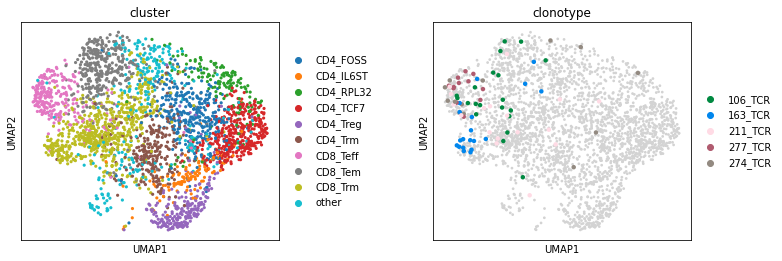

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={"wspace": 0.6})
sc.pl.umap(adata, color="cluster", ax=ax1, show=False)
sc.pl.umap(
    adata,
    color="clonotype",
    groups=top_differential_clonotypes,
    ax=ax2,
    # increase size of highlighted dots
    size=[
        80 if c in top_differential_clonotypes else 30 for c in adata.obs["clonotype"]
    ],
)

### Repertoire overlap of cell types

Just like comparing repertoire overlap among samples, Scirpy also offers comparison between gene expression clusters or cell subpopulations. As an example, repertoire overlap of the two cell types compared above is shown.

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Repertoire overlap between CD8_Teff and CD8_Trm'}, xlabel='Clonotype size in CD8_Teff', ylabel='Clonotype size in CD8_Trm'>

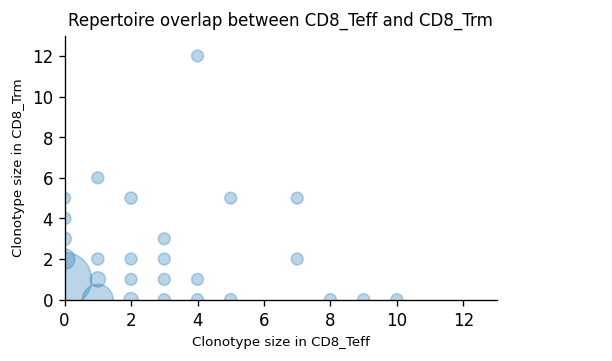

In [54]:
ir.tl.repertoire_overlap(adata, "cluster")
ir.pl.repertoire_overlap(
    adata, "cluster", pair_to_plot=["CD8_Teff", "CD8_Trm"], fig_kws={"dpi": 120}
)

### Marker genes in top clonotypes

Gene expression of cells belonging to individual clonotypes can also be compared using Scanpy. As an example, differential gene expression of two clonotypes, found to be specific to cell type clusters can also be analysed.

ranking genes
    consider 'clonotype' groups:
    with sizes: [19 12]
--> Few observations in a group for normal approximation (<=25). Lower test accuracy.
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


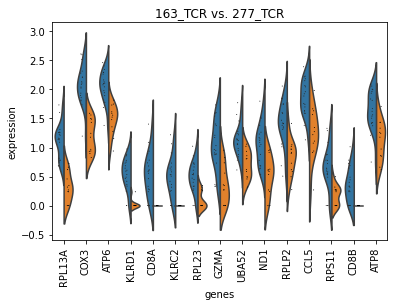

In [55]:
sc.tl.rank_genes_groups(
    adata, "clonotype", groups=["163_TCR"], reference="277_TCR", method="wilcoxon"
)
sc.pl.rank_genes_groups_violin(adata, groups="163_TCR", n_genes=15)